# Use OSMnx to calculate street network indicators

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Documentation](https://osmnx.readthedocs.io/)
  - [Journal article and citation info](https://geoffboeing.com/publications/osmnx-paper/)
  - [Code repository](https://github.com/gboeing/osmnx)
  - [Examples gallery](https://github.com/gboeing/osmnx-examples)

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd

ox.__version__

'2.0.2'

## Calculate basic street network measures (topological and geometric)

In [2]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
stats = ox.stats.basic_stats(ox.graph.graph_from_place("Piedmont, California, USA"))
stats["circuity_avg"]

1.0751643339909156

To calculate density-based stats, you must also pass the network's bounding area in square meters (otherwise basic_stats() will just skip them in the calculation):

In [3]:
# get the street network for a place, and its area in square meters
place = "Piedmont, California, USA"
gdf = ox.geocoder.geocode_to_gdf(place)
area = ox.projection.project_gdf(gdf).union_all().area
G = ox.graph.graph_from_place(place, network_type="drive")

In [4]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.stats.basic_stats(G, area=area)
pd.Series(stats)

n                                                                             352
m                                                                             944
k_avg                                                                    5.363636
edge_length_total                                                   112049.010539
edge_length_avg                                                        118.695986
streets_per_node_avg                                                     2.948864
streets_per_node_counts                  {0: 0, 1: 34, 2: 0, 3: 270, 4: 46, 5: 2}
streets_per_node_proportions    {0: 0.0, 1: 0.09659090909090909, 2: 0.0, 3: 0....
intersection_count                                                            318
street_length_total                                                  58086.346129
street_segment_count                                                          495
street_length_avg                                                      117.346154
circuity_avg    

Streets/intersection counts and proportions are nested dicts inside the stats dict. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [5]:
# unpack dicts into individiual keys:values
stats = ox.stats.basic_stats(G, area=area)
for k, count in stats["streets_per_node_counts"].items():
    stats[f"{k}way_int_count"] = count
for k, proportion in stats["streets_per_node_proportions"].items():
    stats[f"{k}way_int_prop"] = proportion

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name="value")).round(3)

,value
n,352.000
m,944.000
k_avg,5.364
edge_length_total,112049.011
edge_length_avg,118.696
streets_per_node_avg,2.949
intersection_count,318.000
street_length_total,58086.346
street_segment_count,495.000
street_length_avg,117.346


### Inspect betweenness centrality

In [6]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.convert.to_digraph(G), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(53124805, 0.3172161172161172)

In the city of Piedmont, California, the node with the highest betweenness centrality has ~31% of all shortest paths running through it. Let's highlight it in the plot:

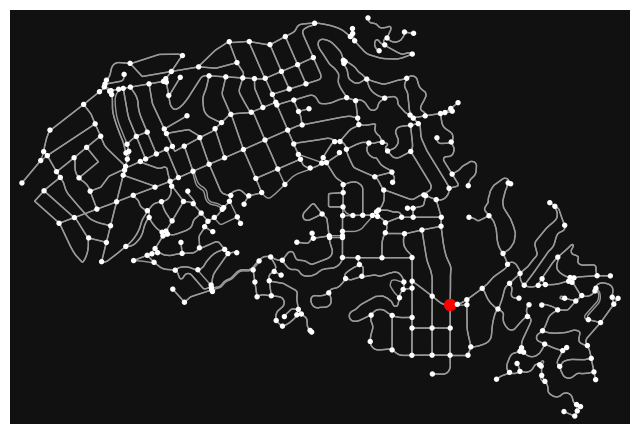

In [7]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

~30% of all shortest paths run through the node highlighted in red. Let's look at the relative betweenness centrality of every node in the graph:

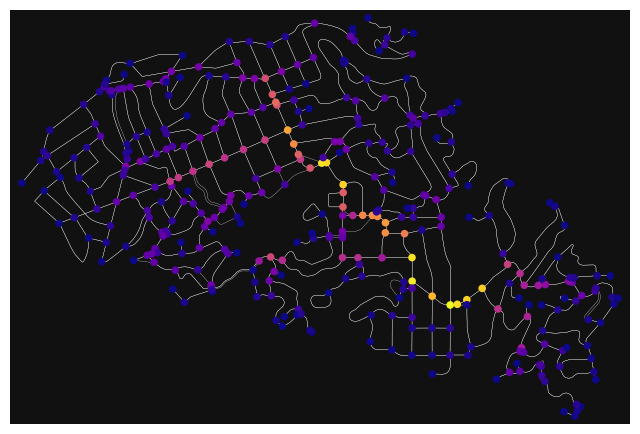

In [8]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.